<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/08_Self_Supervised_TSBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

# TSBERT: Self-Supervised Pretraining of Time Series Models 🤗

This is an unofficial PyTorch implementation created by Ignacio Oguiza (timeseriesAI@gmail.com) based on:

* Zerveas, G., Jayaraman, S., Patel, D., Bhamidipaty, A., & Eickhoff, C. (2020). A Transformer-based Framework for Multivariate Time Series Representation Learning. arXiv preprint arXiv:2010.02803v2.. No official implementation available as far as I know (Oct 10th, 2020)

`TSBERT` is a self-supervised training method that can be used to pretrain time series models without using any labels. The approach is very similar to BERT.

`TSBERT` is performed in 2 steps: 

1. Pretrain the selected architecture without any labels. When training is finished, the pretrained model will be automatically saved to the given target_dir/fname.
2. Fine-tune or train the same architecture with pretrained=True indicating the weights_path (target_dir/fname).


In this notebook we'll use a UCR dataset (LSST) that contains around 2500 training and 2500 validation samples. To analyze the impact of `TSBERT` we'll:
1. use supervised learning to set a baseline using 10% or 100% of the labels.
2. pretrain a model using 100% of the training dataset without labels.
3. fine tune or train using 10% or 100% of the training dataset (with labels). 

A key difference between `TSBERT` and the original paper is that you can use any architecture of your choice as long as it has a "head" attribute and can take a custom_head kwarg. Architectures finished in Plus in the `tsai` library meet this criteria. To demonstrate how this works, we'll use InceptionTimePlus throughout this notebook.

### Results

<img src="https://github.com/timeseriesAI/tsai/blob/master/tutorial_nbs/images/TSBERT_data.jpg?raw=1">
<img src="https://github.com/timeseriesAI/tsai/blob/master/tutorial_nbs/images/TSBERT_chart.jpg?raw=1">

These results indicate the following: 

* Pretraining + fine-tuning/ training improves performance when compared to supervised learning (training from scratch).
* In this case, there's not much difference between fine-tuning and training a pretrained model. This may be dataset dependent. It'd be good to try both approaches. 
* The fewer labels available, the better pretraining seems to work. 

# Import libraries 📚

In [1]:
stable = True # True: latest version, False: stable version

import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if stable: 
        !pip install tsai -q
    else:
        !pip install -Uqq git+https://github.com/timeseriesAI/tsai.git@master
    
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

     |████████████████████████████████| 133kB 4.4MB/s 
     |████████████████████████████████| 92kB 4.3MB/s 
     |████████████████████████████████| 9.5MB 7.8MB/s 
     |████████████████████████████████| 194kB 48.3MB/s 
     |████████████████████████████████| 174kB 52.7MB/s 
     |████████████████████████████████| 5.7MB 28.8MB/s 
     |████████████████████████████████| 22.2MB 1.3MB/s 
     |████████████████████████████████| 296kB 44.1MB/s 
     |████████████████████████████████| 3.2MB 41.5MB/s 
     |████████████████████████████████| 2.5MB 49.6MB/s 
     |████████████████████████████████| 675kB 41.9MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 25.3MB 128kB/s 
     |████████████████████████████████| 102kB 5.6MB/s 
     |████████████████████████████████| 102kB 6.8MB/s 
ERROR: distributed 2021.1.0 has requirement dask>=2020.12.0, but you'll have dask 2.12.0 which is incompatible.
tsai       : 0.2.13
fastai     : 2.2.5
fastcore   : 1.3.

# Prepare data 🏭

We'll first import the data.

In [2]:
dsid = 'LSST'
X, y, splits = get_UCR_data(dsid, split_data=False)

We'll now create 2 dataloaders with 100% of the training and 100% of validation samples.
One of them doesn't contain the y (unlabeled). The other one contains the labels. 
We'll use the unlabeled dataset (udls) to pretrain the model.

X      - shape: [4925 samples x 6 features x 36 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (4925,)  type: memmap  dtype:<U2  n_classes: 14 (351 samples per class) ['15', '16', '42', '52', '53', '6', '62', '64', '65', '67', '88', '90', '92', '95']  isnan: False
splits - n_splits: 2 shape: [2459, 2466]  overlap: [False]


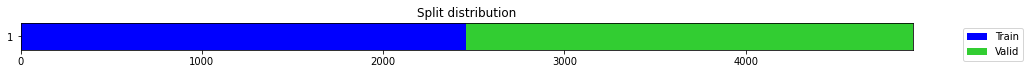

In [3]:
# 100% train data
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
check_data(X, y, splits)
dls100 = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
udls100 = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms) # used in pretraining

We'll also need a labeled dataloaders with 10% of the training and 100% of validation data.

X      - shape: [4925 samples x 6 features x 36 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (4925,)  type: memmap  dtype:<U2  n_classes: 14 (351 samples per class) ['15', '16', '42', '52', '53', '6', '62', '64', '65', '67', '88', '90', '92', '95']  isnan: False
splits - n_splits: 2 shape: [245, 2466]  overlap: [False]


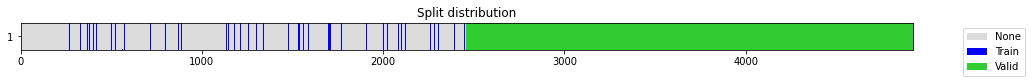

In [4]:
# 10% train data
train_split010 = get_splits(y[splits[0]], valid_size=.1, show_plot=False)[1]
splits010 = (train_split010, splits[1])
check_data(X, y, splits010)
dls010 = get_ts_dls(X, y, splits=splits010, tfms=tfms, batch_tfms=batch_tfms)

# Supervised 👀

First we'll train a model in a supervised way to set a baseline. We'll train using 10% and 100% of the training set. We'll run 10 tests.

10/10 accuracy: 0.565 +/- 0.011


epoch,train_loss,valid_loss,accuracy,time
0,2.661295,2.652655,0.092105,00:00
1,2.370440,2.611886,0.145148,00:00
2,2.113076,2.520723,0.220395,00:00
3,1.904034,2.354614,0.377467,00:00
4,1.728181,1.853241,0.474095,00:00
5,1.596038,1.817940,0.369243,00:00
6,1.471839,2.203474,0.307566,00:00
7,1.400062,5.462129,0.293586,00:00
8,1.332408,5.512117,0.394326,00:00
9,1.282079,5.537936,0.405428,00:00


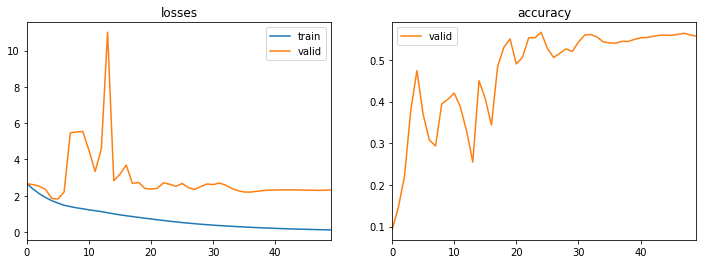


accuracy: 0.564 +/- 0.010 in 10 tests


In [ ]:
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i + 1}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, fc_dropout=.1, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

10/10 accuracy: 0.710 +/- 0.007


epoch,train_loss,valid_loss,accuracy,time
0,1.715435,1.456406,0.527961,00:01
1,1.356148,1.130325,0.627467,00:01
2,1.176708,1.113236,0.641036,00:01
3,1.086074,1.620956,0.526727,00:01
4,1.043658,1.260057,0.604030,00:01
5,1.019038,1.083614,0.636513,00:01
6,0.955949,1.218362,0.623766,00:01
7,0.942597,1.093472,0.644737,00:01
8,0.891876,1.041849,0.678865,00:01
9,0.865070,2.116159,0.440378,00:01


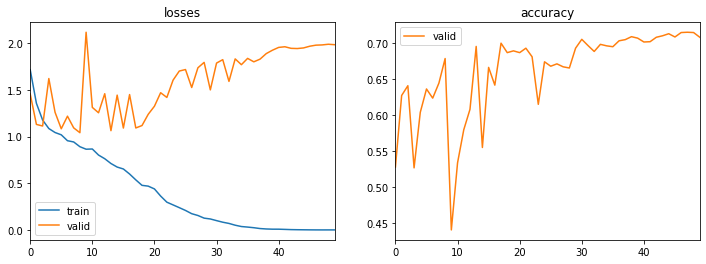


accuracy: 0.710 +/- 0.007 in 10 tests


In [ ]:
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i + 1}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, fc_dropout=.1, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

This is a great result. Just for reference, in a recent review of multivariate time series models (Ruiz, A. P., Flynn, M., Large, J., Middlehurst, M., & Bagnall, A. (2020). The great multivariate time series classification bake off: a review and experimental evaluation of recent algorithmic advances. Data Mining and Knowledge Discovery, 1-49.), the best performing classifier on this dataset is MUSE with an accuracy of 63.62. 
Let's see if we can improve our baseline result with InceptionTime using `TSBERT`.

# Pretrain model  🏋️‍♂️

Now we'll train a model without any labels on the entire training set. To do that we need to use the `TSBERT` callback. You can get more details on this callback visiting [`tsai` documentation](https://timeseriesai.github.io/tsai/callback.TSBERT).

epoch,train_loss,valid_loss,time
0,0.850061,0.721529,00:01
1,0.751499,0.649233,00:02
2,0.694714,0.602616,00:01
3,0.668299,0.593788,00:02
4,0.624369,0.597266,00:02
5,0.607864,0.561294,00:02
6,0.587367,0.605633,00:02
7,0.572272,0.564105,00:02
8,0.572933,0.556885,00:02
9,0.561382,0.574719,00:02


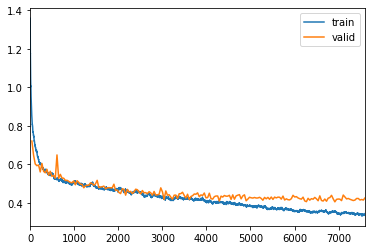


pre-trained model weights_path='data/TSBERT/LSST.pth'



In [13]:
# Unlabeled 100%
learn = ts_learner(udls100, InceptionTimePlus, cbs=[ShowGraph(), TSBERT(target_dir='./data/TSBERT', fname=f'{dsid}')])
learn.fit_one_cycle(200, 1e-2)

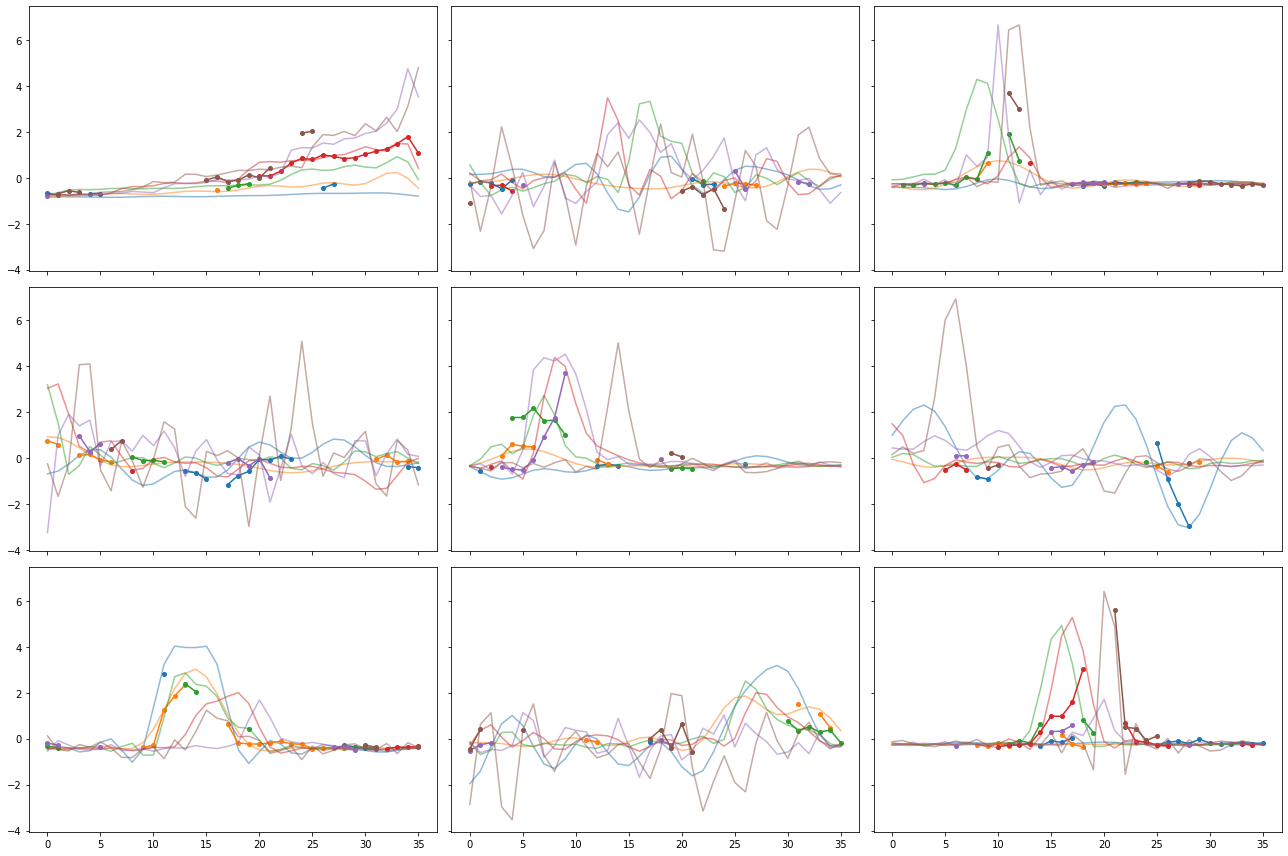

In [14]:
learn.TSBERT.show_preds(sharey=True)

# Fine-tune 🎻

We'll start by fine-tuning the pretrained model. 

When using the entire training set we'll use 20 epochs, but when using just 10% we'll need to use 100 epochs to compensate the much lower number of iterations.

In [ ]:
n_epochs = 100
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i + 1}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, fc_dropout=.1, pretrained=True, weights_path=f'data/TSBERT/{dsid}.pth', metrics=accuracy)
    learn.fine_tune(n_epochs)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.619 +/- 0.007
weights from data/TSBERT/LSST.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.593811,2.553604,0.326480,00:00


epoch,train_loss,valid_loss,accuracy,time
0,2.553312,2.537278,0.328947,00:00
1,2.534436,2.519916,0.334293,00:00
2,2.522864,2.502594,0.341283,00:00
3,2.509938,2.485368,0.345395,00:00
4,2.504264,2.466630,0.350329,00:00
5,2.495297,2.447295,0.356086,00:00
6,2.483001,2.426592,0.364309,00:00
7,2.469170,2.402993,0.369243,00:00
8,2.456353,2.377486,0.376234,00:00
9,2.442139,2.348272,0.384868,00:00



accuracy: 0.620 +/- 0.007 in 10 tests


62% is pretty close to the state-of-the-art accuracy using supervised training and 100% of the data. In this case we are just using 10% of the labels. 

In [ ]:
n_epochs = 20
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i + 1}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, fc_dropout=.1, pretrained=True, weights_path=f'data/TSBERT/{dsid}.pth', metrics=accuracy)
    learn.fine_tune(n_epochs)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.721 +/- 0.005
weights from data/TSBERT/LSST.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.430416,1.859949,0.495066,00:01


epoch,train_loss,valid_loss,accuracy,time
0,1.852687,1.752829,0.502056,00:01
1,1.744425,1.576093,0.527549,00:01
2,1.598968,1.369678,0.564967,00:01
3,1.445886,1.226298,0.596628,00:01
4,1.296385,1.101412,0.629934,00:01
5,1.172196,1.013444,0.682155,00:01
6,1.067037,0.978217,0.683388,00:01
7,0.981155,0.936919,0.700658,00:01
8,0.913889,0.908189,0.708059,00:01
9,0.853375,0.895386,0.709293,00:01



accuracy: 0.721 +/- 0.005 in 10 tests


Performance is better than with the supervised method when using all labels. And training is also much smoother.

# Train 🏃🏽‍♀️

It'd also be interesting to compare fine-tuning to training. 

In [ ]:
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i + 1}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i + 1}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, fc_dropout=.1, pretrained=True, weights_path=f'data/TSBERT/{dsid}.pth', metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

10/10 accuracy: 0.604 +/- 0.011
weights from data/TSBERT/LSST.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.620420,2.597124,0.041118,00:00
1,2.601204,2.546525,0.109375,00:00
2,2.569565,2.457177,0.273026,00:00
3,2.525368,2.312121,0.446135,00:00
4,2.458810,2.110248,0.470395,00:00
5,2.376624,1.903196,0.475329,00:00
6,2.279661,1.725292,0.481086,00:00
7,2.176907,1.560805,0.502056,00:00
8,2.072539,1.561529,0.540707,00:00
9,1.959574,1.443869,0.571546,00:00



accuracy: 0.606 +/- 0.012 in 10 tests


In [ ]:
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i + 1}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i + 1}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, fc_dropout=.1, pretrained=True, weights_path=f'data/TSBERT/{dsid}.pth', metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

10/10 accuracy: 0.725 +/- 0.008
weights from data/TSBERT/LSST.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.472939,2.229035,0.475740,00:01
1,2.143723,1.662844,0.501234,00:01
2,1.772022,1.301775,0.563734,00:01
3,1.461249,1.091599,0.622533,00:01
4,1.217117,0.961982,0.685033,00:01
5,1.036117,0.994021,0.675576,00:01
6,0.890134,1.056876,0.669819,00:01
7,0.791551,1.015171,0.675164,00:01
8,0.719434,1.066320,0.655016,00:01
9,0.645488,1.126208,0.686266,00:01



accuracy: 0.725 +/- 0.007 in 10 tests


The results here are also very good. It's difficult to know a priori which of the 2 methods is best. I'd encourage you to try both. In both cases performance is better than supervised training.

# Conclusions ✅

`TSBERT` is the first self-supervised method added to the `tsai` library. And it seems to work pretty well. It shows something really interesting: self-supervised learning may be improve performance, with or without additional unlabeled data.

In this notebook we've demonstrated how eady it is to use a self-supervised method in 2 steps: 

1. pretrain an architecture using the `TSBERT` callback.
2. fine-tune or train the same architecture using the pretrained model weights.

`TSBERT` has shown it can improve performance with a low number of labels (10%) as well as with all labels (100%). 

I'd encourage you to use `TSBERT` with your own datasets and share your experience.